In [1]:
import json
import os
import matplotlib.pyplot as plt
from pylab import mpl
import pylab

# 1. Explore the dataset 

## 1.1 Load data

In [2]:
data_path="../dutch_data/"
filenames=os.listdir(data_path)

In [3]:
filenames

['dutch1.json', 'dutch4.json', 'dutch2.json', 'dutch3.json']

In [4]:
datas=[]
for filename in filenames:
    with open(r'../dutch_data/'+filename, 'r') as f:
        datas+=json.load(f)
        print(len(datas))

5200
10500
14700
18000


In [5]:
sentiment_map={}
for data in datas:
    if 'sentiment' in data and data['sentiment']!="":
        if data['sentiment'] not in sentiment_map:
            sentiment_map[data['sentiment']]=[data['content']]
        else:
            sentiment_map[data['sentiment']]=sentiment_map[data['sentiment']]+[data['content']]
print("Classes:")       
print(list(sentiment_map.keys()))
print("Num of Positive:")  
print(len(sentiment_map['positive']))
print("Num of Negative:")  
print(len(sentiment_map['negative']))
print("Num of Neutral:")  
print(len(sentiment_map['neutral']))
print("Num of Not Sure:")  
print(len(sentiment_map['not sure']))

Classes:
['neutral', 'positive', 'negative', 'not sure']
Num of Positive:
759
Num of Negative:
179
Num of Neutral:
2228
Num of Not Sure:
148


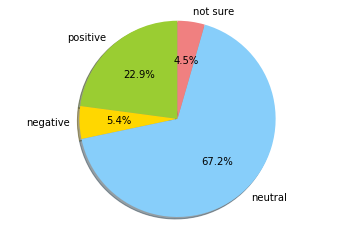

In [6]:
# Pie chart
label=['positive','negative','neutral','not sure']
size=[len(sentiment_map['positive']),len(sentiment_map['negative']),len(sentiment_map['neutral']),len(sentiment_map['not sure'])]
colors=['yellowgreen','gold','lightskyblue','lightcoral']
plt.pie(size,labels=label,colors=colors,autopct='%1.1f%%',shadow=True,startangle=90)
plt.axis('equal')
plt.show()

## 1.2 Word frequency by sentiment

In [7]:
import nltk
import numpy as np
import re

In [8]:
#load stopwords
with open(r'../data/dutch_stopwords.txt', 'r') as f:
    stopwords=f.readlines()
    stopwords=[stopword.strip() for stopword in stopwords]

In [59]:
stopwords[0:5]

['aan', 'aangaande', 'aangezien', 'achte', 'achter']

In [10]:
# remove punctuations and stopwords
def text_clean(text):
    # lower
    text=text.lower()
    # remove punctuations
    text=re.sub("[^a-zA-Z]", " ", text)
    # word tokenize
    word_list = nltk.word_tokenize(text)
    # word filter
    word_list=[word for word in word_list if word not in stopwords and len(word)>1]
    return word_list

# word count
def word_count(data_lists):
    # join data
    text=" ".join(data_lists)
    word_list=text_clean(text)
    freq_dist = nltk.FreqDist(word_list)
    return freq_dist

pos_freq=word_count(sentiment_map['positive'])
neg_freq=word_count(sentiment_map['negative'])
neu_freq=word_count(sentiment_map['neutral'])
ns_freq=word_count(sentiment_map['not sure'])

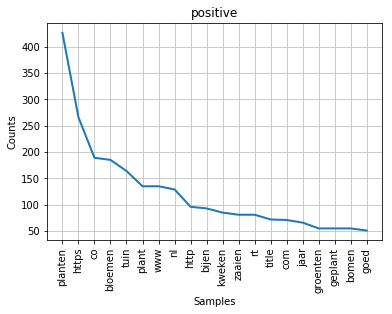

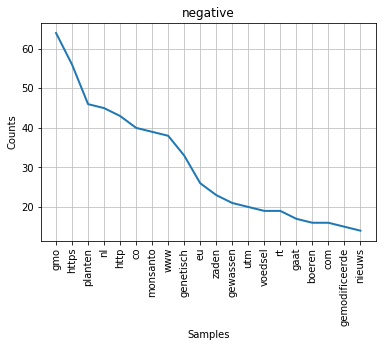

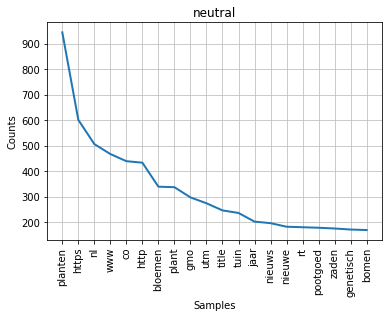

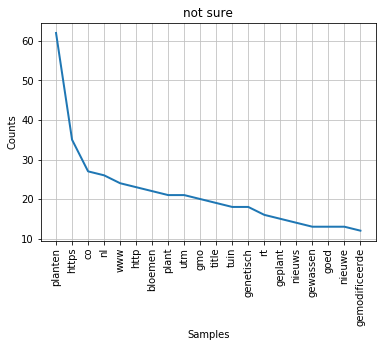

In [11]:
pos_freq.plot(20,title='positive')
neg_freq.plot(20,title='negative')
neu_freq.plot(20,title='neutral')
ns_freq.plot(20,title='not sure')

## Remove neutral word

From the above pictures we can easily find that positive and negative sentiment have many identical words (such as http, www) and these words are some neutral words. We can remove them to get more emotional words.

In [17]:
# convert freq_dist to numpy array
def dist2array(freq_dist):
    freq_list = []
    num_words = len(freq_dist.values())
    for i in range(num_words):
        freq_list.append([list(freq_dist.keys())[i],list(freq_dist.values())[i]])
    freq_list = sorted(freq_list,key=lambda x:x[1],reverse=True)
    freqArr = np.array(freq_list)
    return freqArr

pos_array=dist2array(pos_freq)
neg_array=dist2array(neg_freq)
neu_array=dist2array(neu_freq)
ns_array=dist2array(ns_freq)

In [18]:
pos_array[:5]

array([['planten', '426'],
       ['https', '266'],
       ['co', '189'],
       ['bloemen', '185'],
       ['tuin', '164']], dtype='<U31')

In [19]:
neutral_word=list(set(pos_array[:200,0]).intersection(set(neg_array[:200,0])))

In [20]:
neutral_word[0:5]

['artikel', 'groeien', 'genetisch', 'voedsel', 'gmo']

<BarContainer object of 20 artists>

/home/yifan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


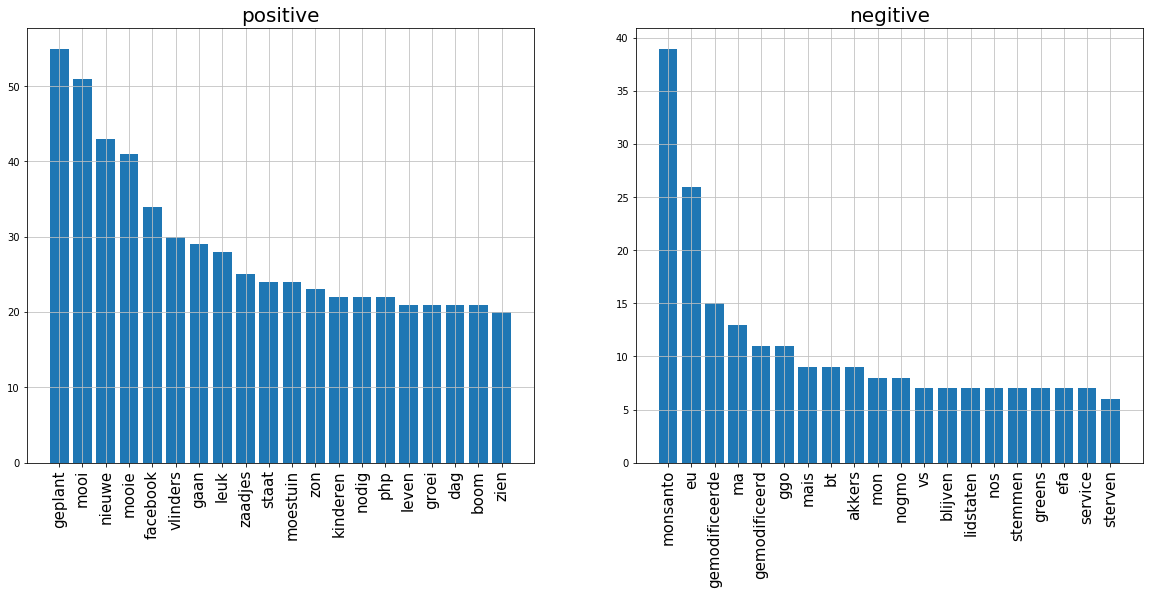

In [21]:
#Re-drawing

num=20
plt.figure(figsize = (20, 8))
mpl.rcParams['font.sans-serif'] = ['FangSong']  
mpl.rcParams['axes.unicode_minus'] = False

plt.subplot(121)
tmp = np.array([x for x in pos_array[:] if x[0] not in neutral_word])[:num]
label=tmp[:,0]
value=[int(x) for x in tmp[:,1]]
pylab.title('positive',fontsize=20)
pylab.xticks(range(len(value)),label, rotation=90,fontsize=15)
pylab.grid(True, color="silver")
plt.bar(range(len(value)), value, tick_label=label)


plt.subplot(122)
tmp = np.array([x for x in neg_array[:] if x[0] not in neutral_word])[:num]
label=tmp[:,0]
value=[int(x) for x in tmp[:,1]]
pylab.title('negitive',fontsize=20)
pylab.xticks(range(len(value)),label, rotation=90,fontsize=15)
pylab.grid(True, color="silver")
plt.bar(range(len(value)), value, tick_label=label)

## personal opinion

From my point of view, all words after the exclusion of high frequency neutral words and stopwords may contain part of the sentiment.Play a large part in model decision making.
However,the number of samples is too small, many features cannot be observed.

# 2.  Feature Extraction 

In [22]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

In [23]:
texts=sentiment_map['negative']+sentiment_map['positive']+sentiment_map['neutral']

def text_clean2(text):
    # lower
    text=text.lower()
    # remove punctuations
    text=re.sub("[^a-zA-Z]", " ", text)
    # word tokenize
    word_list = nltk.word_tokenize(text)
    # word filter
    word_list=[word for word in word_list if word not in stopwords and len(word)>1]
    return " ".join(word_list)

#clean text and create labels
labels=[]
for i,text in enumerate(texts):
    texts[i]=text_clean2(text)
    if i<len(sentiment_map['negative']):
        labels.append(0)
    elif i<len(sentiment_map['positive'])+len(sentiment_map['negative']):
        labels.append(1)
    elif i<len(texts):
        labels.append(2)
labels=np.array(labels)

In [61]:
vectorizer = CountVectorizer()
freq_table = vectorizer.fit_transform(texts)
freq_table = freq_table.toarray()

In [66]:
print("Total number of examples: "+str(len(freq_table)))
print("Total number of vocabs: "+str(len(freq_table[0])))

Total number of examples: 3166
Total number of vocabs: 15384


In [64]:
freq_table

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [65]:
freq_table.sum(axis=0)

array([3, 1, 2, ..., 1, 2, 1], dtype=int64)

# 3.  Modeling

## 3.1 Data split and weight calculation

In [27]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts,labels,
                                                    train_size=0.9,random_state=30,shuffle=True)

/home/yifan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [28]:
import numpy as np
def weight_fun(x):
    sum_x=sum(x)
    weight=sum_x/x
    weight=weight/min(weight)
    return weight

In [29]:
# weight balance
class_sample_count=np.array([len(np.where(y_train==t)[0]) for t in np.unique(y_train)])
weight=weight_fun(class_sample_count)
w=np.array([weight[t] for t in y_train])

In [30]:
class_sample_count

array([ 171,  677, 2001])

In [31]:
# sample weights
w[:10]

array([ 1.        ,  1.        ,  1.        , 11.70175439,  2.95568685,
        1.        ,  1.        ,  1.        ,  2.95568685,  1.        ])

In [32]:
y_train[:10]

array([2, 2, 2, 0, 1, 2, 2, 2, 1, 2])

## 3.2 XGBoost Machine Learning Algorithm

Reason for choice:
1. XGBoost has always had good results in text classification.

2. Simple model building



In [33]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

vectorizer = CountVectorizer()
tfidftransformer = TfidfTransformer()
tfidf = tfidftransformer.fit_transform(vectorizer.fit_transform(X_train))
train_data = tfidf.toarray()
print(train_data.shape)
test_tfidf = tfidftransformer.transform(vectorizer.transform(X_test))
test_data = test_tfidf.toarray()
print(test_data.shape)

(2849, 14359)
(317, 14359)


In [35]:
import xgboost as xgb
import pickle
model_path="../model/"
filenames=os.listdir(model_path)
if "xgb.pickle.dat" in filenames:
    bst = pickle.load(open(model_path+"xgb.pickle.dat", "rb"))
    dtest = xgb.DMatrix(test_data)  
else:
    dtrain = xgb.DMatrix(train_data, label=y_train,weight=w)
    dtest = xgb.DMatrix(test_data)  
    param = {'max_depth':5, 'eta':0.5, 'eval_metric':'merror', 'silent':1, 'objective':'multi:softmax', 'num_class':3}  # 参数
    evallist  = [(dtrain,'train')]  
    num_round = 300
    bst = xgb.train(param, dtrain, num_round, evallist)
    pickle.dump(bst, open(model_path+"xgb.pickle.dat", "wb"))
preds = bst.predict(dtest)

In [36]:
preds[:20]

array([2., 2., 1., 2., 2., 2., 1., 2., 2., 2., 2., 1., 2., 2., 2., 2., 0.,
       1., 2., 2.], dtype=float32)

In [37]:
# accuracy
from sklearn.metrics import accuracy_score
y_pred = bst.predict(dtest)
accuracy=accuracy_score(y_test, y_pred)
print("accuracy: "+str(accuracy))

accuracy: 0.6593059936908517


In [38]:
# classification report
from sklearn.metrics import classification_report
target_names=['negative','positive','neutral']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00         8
   positive       0.45      0.41      0.43        82
    neutral       0.76      0.77      0.77       227

avg / total       0.66      0.66      0.66       317



/home/yifan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


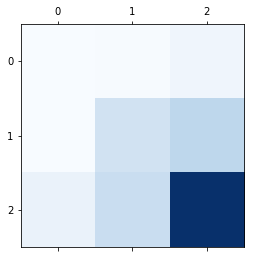

In [40]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
plt.matshow(cm,cmap=plt.cm.Blues)

# 3.3 FastText Algorithm¶

Reason for choice:
1. Fast training

2. FastText focuses on text classification

3. Trained and used excellent word vectors

In [41]:
import fasttext

In [42]:
data_path="../data/"
model_path="../model/"
with open(data_path+"fasttext_train.txt","w") as f:
    for i,x in enumerate(X_train):
        s=x+"\t"+"__label__"+str(y_train[i])+"\n"
        s=s*round(float(weight[y_train[i]]))
        f.write(s)
        
with open(data_path+"fasttext_test.txt","w") as f:
    for i,x in enumerate(X_test):
        s=x+"\t"+"__label__"+str(y_test[i])+"\n"
        f.write(s)



In [68]:
classifier=fasttext.supervised(data_path+"fasttext_train.txt",model_path+"fasttext.model",label_prefix="__label__",epoch=500,dim=128)

In [69]:
classifier=fasttext.load_model(model_path+"fasttext.model.bin",label_prefix="__label__")
result=classifier.test(data_path+"fasttext_test.txt")

In [70]:
classifier.labels

['0', '1', '2']

In [71]:
y_pred=np.array(classifier.predict(X_test)).flatten().astype(int)

In [72]:
y_pred[:10]

array([2, 2, 1, 2, 2, 2, 1, 2, 0, 2])

In [73]:
y_test[:10]

array([2, 2, 1, 2, 1, 2, 2, 2, 1, 2])

In [74]:
# accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test, y_pred)
print("accuracy: "+str(accuracy))

accuracy: 0.6971608832807571


In [75]:
# classification report
from sklearn.metrics import classification_report
target_names=['negative','positive','neutral']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00         8
   positive       0.50      0.49      0.49        82
    neutral       0.79      0.80      0.79       227

avg / total       0.70      0.70      0.70       317



In [51]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
plt.matshow(cm,cmap=plt.cm.Blues)

/home/yifan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


# 3.4 TextCNN

Reason for choice:
1.  Very good model, according to my previous experience, the effect of TextCNN is often better than the model based on Recurrent Neural Network such as LSTM.

In [52]:
#create datafile
data_path="../data/"
with open(data_path+"textcnn_train.txt","w") as f:
    for i,x in enumerate(X_train):
        s=str(y_train[i])+"\t"+x+"\n"
        s=s*round(float(weight[y_train[i]]))
        f.write(s)
        
with open(data_path+"textcnn_test.txt","w") as f:
    for i,x in enumerate(X_test):
        s=str(y_test[i])+"\t"+x+"\n"
        f.write(s)


### Omit the training process, the specific code is in “model/TEXTCNN/train.py”

In [54]:
#evaluation
import sys
sys.path.append('../model/textcnn/')
import tensorflow as tf
import numpy as np
import os
import time
import datetime
import data_helper
from TextCNN import TextCNN
from tensorflow.contrib import learn
import csv

# Data Parameters
data_file="../data/textcnn_test.txt"
checkpoint_dir="../model/textcnn/runs/1535929137/checkpoints"
vocab_path="../model/textcnn/runs/1535929137/vocab"
batch_size=64

# CHANGE THIS: Load data. Load your own data here
x_raw, y_test = data_helper.load_data(data_file)
y_test = np.argmax(y_test, axis=1)

# Map data into vocabulary
print(vocab_path)
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)
x_test = np.array(list(vocab_processor.transform(x_raw)))

print("\nEvaluating...\n")

# Evaluation
# ==================================================
#得到最近保存的模型
#checkpoint_file = "./runs/1516092210/checkpoints/"
checkpoint_file = tf.train.latest_checkpoint(checkpoint_dir)
graph = tf.Graph()
with graph.as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=True,
      log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        # Load the saved meta graph and restore variables
        saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
        saver.restore(sess, checkpoint_file)

        # Get the placeholders from the graph by name
        input_x = graph.get_operation_by_name("input_x").outputs[0]
        # input_y = graph.get_operation_by_name("input_y").outputs[0]
        dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0]

        # Tensors we want to evaluate
        predictions = graph.get_operation_by_name("output/predictions").outputs[0]

        # Generate batches for one epoch
        batches = data_helper.batch_iter(list(x_test), batch_size, 1, shuffle=False)

        # Collect the predictions here
        y_pred = []

        for x_test_batch in batches:
            batch_predictions = sess.run(predictions, {input_x: x_test_batch, dropout_keep_prob: 1.0})
            y_pred = np.concatenate([y_pred, batch_predictions])
            

../model/textcnn/runs/1535929137/vocab

Evaluating...

INFO:tensorflow:Restoring parameters from /home/yifan/workspace/digitalmr/dutch_sentiment/model/TextCNN/runs/1535929137/checkpoints/model-4300


In [55]:
# accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test, y_pred)
print("accuracy: "+str(accuracy))

accuracy: 0.6750788643533123


In [56]:
# classification report
from sklearn.metrics import classification_report
target_names=['negative','positive','neutral']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   negative       0.08      0.12      0.10         8
   positive       0.48      0.50      0.49        82
    neutral       0.79      0.76      0.77       227

avg / total       0.69      0.68      0.68       317



/home/yifan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


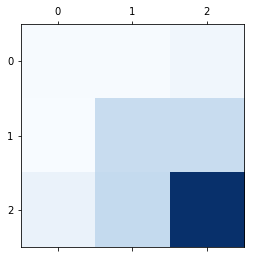

In [57]:
#confusion_matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
plt.matshow(cm,cmap=plt.cm.Blues)

# 4. Conclusion

### Model comparison table


| | XGBoost | FastText | TextCNN |
|  :------ | :------ | :------ | :------ |
| accuracy | 0.659 | 0.697 | 0.675 |
| precision | 0.66 | 0.7 | 0.69 |
| recall | 0.66 | 0.7 | 0.68 |
| f1-score | 0.66 | 0.7 | 0.68 |


From the above table we can see that the fasttext model has a better f1 score. But it only achieves 70% accuracy.

I think the main reason is that the sample size is too small, and the sum of all the samples is only about 2000. Although I adjusted the weight of each sentiment and sample generation methods to reduce the impact of too small a sample size. But it is undeniable that the sample is too small to train a good model.

There are still many areas where the model can be improved, such as using IDA or PCA to reduce the dimensions of tf-idf and remove irrelevant information. Or use a composite model to get better model results.